<a href="https://colab.research.google.com/github/Oksana0020/DL-with-PyTorch/blob/main/Lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Prepare Synthetic Sequential Data

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math

In [3]:

# Create a repeating sequence
sequence = "abcabcabcabcabc"  # Simple repeating pattern
chars = sorted(list(set(sequence)))  # Get unique characters

# Create character to index mappings
char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for ch, idx in char_to_idx.items()}

# Convert sequence to numerical format
sequence_indices = [char_to_idx[ch] for ch in sequence]

# Create input and target tensors
input_tensor = torch.tensor(sequence_indices[:-1], dtype=torch.float32).view(1, -1, 1)
target_tensor = torch.tensor(sequence_indices[1:], dtype=torch.long).view(1, -1)

print(f"Character mappings: {char_to_idx}")
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")

Character mappings: {'a': 0, 'b': 1, 'c': 2}
Input tensor shape: torch.Size([1, 14, 1])
Target tensor shape: torch.Size([1, 14])


# Task 2: Build the RNN Model

In [4]:


class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BasicRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size)

# Initialize model with appropriate dimensions
input_size = 1  # Single feature (character index)
hidden_size = 16  # Hidden layer size
output_size = len(chars)  # Number of possible characters
model = BasicRNN(input_size, hidden_size, output_size)

print(model)

BasicRNN(
  (rnn): RNN(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)


# Task 3: Train the RNN

Epoch 0, Loss: 1.1109


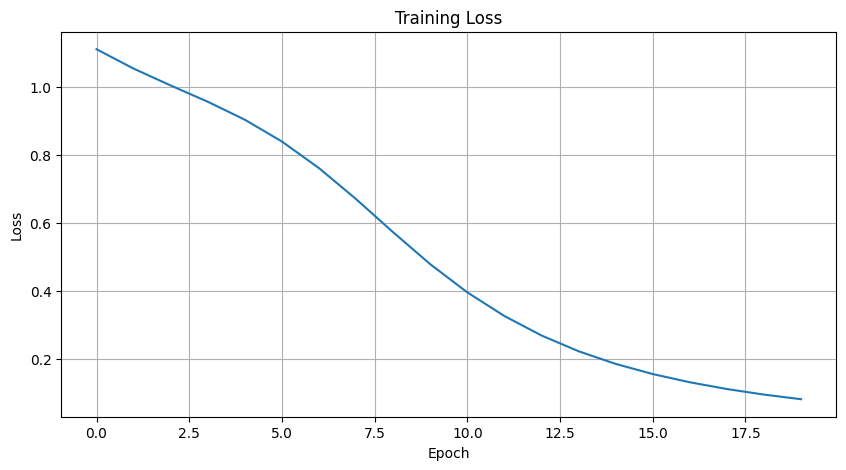

In [5]:

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 20
losses = []

for epoch in range(n_epochs):
    # Initialize hidden state
    hidden = model.init_hidden()

    # Forward pass
    output, hidden = model(input_tensor, hidden)

    # Reshape output for loss calculation
    output = output.view(-1, output_size)
    target = target_tensor.view(-1)

    # Calculate loss
    loss = criterion(output, target)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store loss
    losses.append(loss.item())

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Plot loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


# Task 4: Evaluate and Visualize Results

Input sequence: abcabcabcabcab
Target sequence: bcabcabcabcabc
Predicted sequence: bcabcabcabcabc


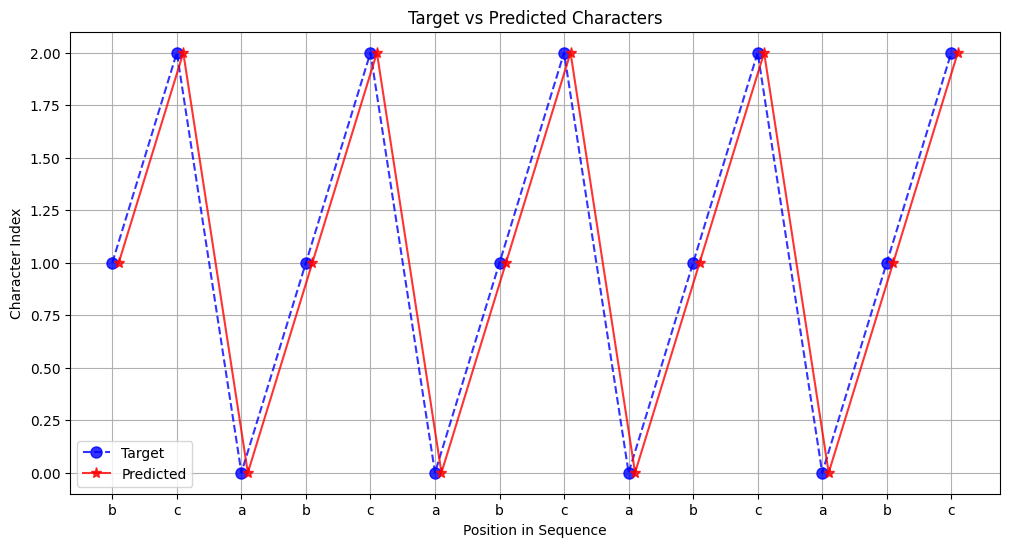

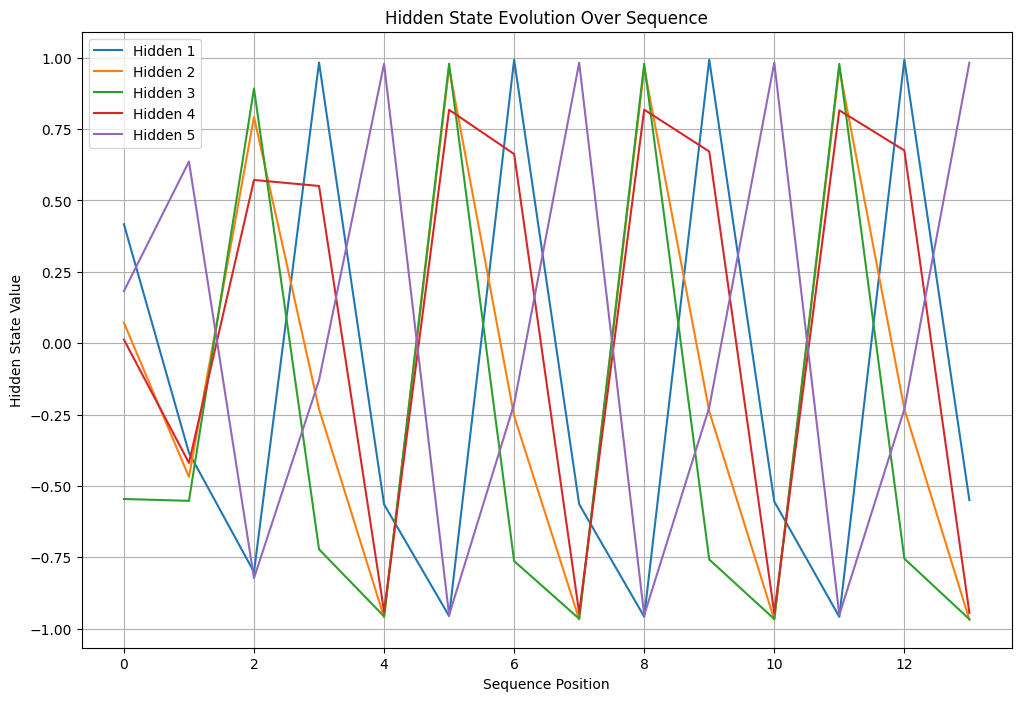

In [6]:


# Set model to evaluation mode
model.eval()

# Generate predictions
with torch.no_grad():
    hidden = model.init_hidden()
    output, hidden = model(input_tensor, hidden)

    # Get predicted indices
    _, predicted_indices = torch.max(output.view(-1, output_size), 1)
    predicted_chars = [idx_to_char[idx.item()] for idx in predicted_indices]

    # Convert input to characters for comparison
    input_chars = [idx_to_char[int(idx.item())] for idx in input_tensor.view(-1)]
    target_chars = [idx_to_char[idx.item()] for idx in target_tensor.view(-1)]

print(f"Input sequence: {''.join(input_chars)}")
print(f"Target sequence: {''.join(target_chars)}")
print(f"Predicted sequence: {''.join(predicted_chars)}")

# Visualize predictions vs targets
plt.figure(figsize=(12, 6))
# Plot target with distinct style
plt.plot(range(len(target_chars)), [char_to_idx[c] for c in target_chars],
         'bo--', label='Target', markersize=8, alpha=0.8)
# Plot predicted with distinct style and slight offset for visibility
plt.plot([x + 0.1 for x in range(len(predicted_chars))], [char_to_idx[c] for c in predicted_chars],
         'r*-', label='Predicted', markersize=8, alpha=0.8)
plt.title('Target vs Predicted Characters')
plt.xlabel('Position in Sequence')
plt.ylabel('Character Index')
plt.xticks(range(len(target_chars)), target_chars)  # Show characters on x-axis
plt.grid(True)
plt.legend()
plt.show()

# Visualize hidden state evolution
with torch.no_grad():
    hidden = model.init_hidden()
    hidden_states = []

    for i in range(input_tensor.size(1)):
        # Process one character at a time
        char_input = input_tensor[:, i:i+1, :]
        _, hidden = model(char_input, hidden)
        hidden_states.append(hidden.clone().view(-1).numpy())

    hidden_states = np.array(hidden_states)

# Plot hidden state evolution
plt.figure(figsize=(12, 8))
for i in range(min(hidden_size, 5)):  # Show first 5 dimensions
    plt.plot(hidden_states[:, i], label=f'Hidden {i+1}')
plt.title('Hidden State Evolution Over Sequence')
plt.xlabel('Sequence Position')
plt.ylabel('Hidden State Value')
plt.legend()
plt.grid(True)
plt.show()